In [ ]:
import numpy as np
from numba import njit
import numba as nb

In [ ]:
@njit
def internal_mean(arr):
    '''
    same as np.mean(arr, axis=1), but jitted
    since numba does not support kwargs in np.mean
    '''
    assert len(arr.shape) == 3
    assert arr.shape[1] == 2

    out = np.zeros((arr.shape[0], arr.shape[2]), dtype=arr.dtype)
    for i, (v1, v2) in enumerate(arr):
        out[i] = (v1 + v2) / 2

    return out


In [ ]:
from rmsd import kabsch_rotate
from python_functions import rmsd_and_max
from algebra import internal_mean, vec_mean

@njit
def rmsd_and_max_jit(P, Q):
    '''
    ** ADAPTED FROM THE PYTHON RMSD LIBRARY **

    Rotate matrix P unto Q using Kabsch algorithm and calculate the RMSD.
    Returns RMSD and max deviation.

    Parameters
    ----------
    P : array
        (N,D) matrix, where N is points and D is dimension.
    Q : array
        (N,D) matrix, where N is points and D is dimension.

    Returns
    -------
    rmsd : float
        root-mean squared deviation
    max_delta : float
        maximum deviation value
    '''

    Q -= vec_mean(Q)
    P -= vec_mean(P)
    P = kabsch_rotate_jit(P, Q)

    diff = Q - P
    rmsd = np.sqrt((diff * diff).sum() / len(diff))
    max_delta = np.max(internal_mean(diff))

    return rmsd, max_delta

@njit
def kabsch_rotate_jit(P, Q):
    # Computation of the covariance matrix
    C = np.dot(np.transpose(P), Q)

    V, S, W = np.linalg.svd(C)
    d = (np.linalg.det(V) * np.linalg.det(W)) < 0.0

    if d:
        S[-1] = -S[-1]
        V[:, -1] = -V[:, -1]

    # Create Rotation matrix U
    U = np.dot(V, W)

    return np.dot(P, U)


In [ ]:
from algebra import internal_mean

x = np.random.rand(10, 100, 3)
a = np.mean(x, axis=1)
b = internal_mean(x)
np.allclose(a,b)

In [ ]:
from cclib.io import ccread
data = ccread(r'C:\Users\ehrma\Desktop\cool_structs\Ph2PAla\Ph2PAla_confs_opt.xyz')
data.atomcoords.shape

In [ ]:
r = [(i,rmsd_and_max(data.atomcoords[0], data.atomcoords[i])) for i in range(len(data.atomcoords))]
r

In [ ]:
print(f'keep {len([i for i in r if i[1][0] < 2])}/{len(r)}')

In [ ]:
from algebra import get_inertia_moments
from pt import pt
masses = np.array([pt[i].mass for i in data.atomnos])
r = [(i,get_inertia_moments(data.atomcoords[i], masses)) for i in range(len(data.atomcoords))]
r

In [ ]:
[(i,np.max(np.abs(a[1]-r[0][1]))) for i,a in enumerate(r)]

In [ ]:
from algebra import center_of_mass
def MOI(coords, masses):
    coords -= center_of_mass(coords, masses)
    return np.sum([masses[i]*np.linalg.norm(coords[i])**2 for i in range(len(coords))])

MOI(data.atomcoords[0], masses)

In [ ]:
r = [(i,MOI(data.atomcoords[i], masses)) for i in range(len(data.atomcoords))]
[(i,np.max(np.abs(a[1]-r[0][1]))) for i,a in enumerate(r)]

In [ ]:
import networkx as nx
edges = [(7, 7), (7, 9), (7, 13), (7, 6), (9, 9), (9, 10), (9, 31), (10, 10), (10, 11), (10, 32), (11, 11), (11, 12), (11, 33), (12, 12), (12, 13), (12, 34), (13, 13), (13, 35), (31, 31), (32, 32), (33, 33), (34, 34), (35, 35)]
G = nx.Graph(edges)
nx.draw(G, with_labels=True)

In [ ]:
d = {}
for i in (31,32,33,34,35):
    d[i] = 1
for i in (7,9,10,11,12,13):
    d[i] = 6
d[6] = 15
d[345] = 45
nx.set_node_attributes(G, d, 'atomnos')
# G.nodes[6]['atomnos']
nx.get_node_attributes(G, 'atomnos')

In [ ]:
import os
os.chdir(r'C:\Users\ehrma\Desktop\Coding\TSCoDe')
from graph_manipulations import get_sp_n
for node in G.nodes:
    print(f'{node}: sp{get_sp_n(node, G)}')

## Vibrations

In [1]:
from tscode.ase_manipulations import ase_vib
from cclib.io import ccread
import numpy as np
data = ccread(r'C:\Users\Nik\Desktop\maleimide\TSCoDe_TS_guesses_mal.xyz')
data.atomcoords.shape

(4, 36, 3)

In [5]:
import asyncio, time
from tscode.utils import time_to_string

embedder = ('MOPAC', 'PM6', None, 'thf') # calculator, method, procs, solvent
# for i, coords in enumerate(data.atomcoords):
#     freqs = ase_vib(embedder, coords, data.atomnos, title=f'temp{i}', logfunction=print)


async def main():

    # freqs = await asyncio.gather(*[asyncio.sleep(0.2) for i, coords in enumerate(data.atomcoords)])
    negatives = await asyncio.gather(*[ase_vib(embedder, coords, data.atomnos, title=f'temp{i}', logfunction=print)[1]
                                       for i, coords in enumerate(data.atomcoords)])
    # print(i, np.count_nonzero(freqs.imag > 1e-3), 'negative freqs')

    return negatives

t = time.perf_counter()
# main()
asyncio.run(main())
print(time_to_string(time.perf_counter()-t))

RuntimeError: asyncio.run() cannot be called from a running event loop

Check enantiomer pruning

In [3]:
from python_functions import torsion_comp_check
from utils import read_xyz
import numpy as np

(34, 141, 3)

In [5]:
data = read_xyz(r'C:\Users\Nik\Desktop\P2\binding_mode\csearch_bind\poses!.xyz')
data.atomcoords.shape

(2, 141, 3)

In [9]:
from algebra import get_inertia_moments
from tscode.pt import pt

heavy_structures = np.array([structure[data.atomnos != 1] for structure in data.atomcoords])
heavy_masses = np.array([pt[a].mass for a in data.atomnos if a != 1])


a = get_inertia_moments(heavy_structures[0], heavy_masses)
b = get_inertia_moments(heavy_structures[1], heavy_masses)

In [12]:
np.abs(a-b)/a*100

array([4.04336112, 0.33132288, 2.0956229 ])

In [13]:
from tscode.algebra import get_moi_similarity_matches

get_moi_similarity_matches(heavy_structures, heavy_masses)

[]

In [15]:
masses = np.array([pt[a].mass for a in data.atomnos])


a = get_inertia_moments(data.atomcoords[0], masses)
b = get_inertia_moments(data.atomcoords[1], masses)
np.abs(a-b)/a*100

array([3.89640628, 0.17445072, 1.81526534])

## Cyclical embed benchmark

In [3]:
from tscode.embedder import Embedder
from tscode.embeds import cyclical_embed, _fast_bimol_rigid_cyclical_embed
import os

filename = r'C:\Users\Nik\Desktop\P2\binding_mode\csearch_bind\monobound\csearch.txt'

embedder = Embedder(filename, stamp='benchmark')
# initialize embedder from input file


*************************************************************
*      TSCoDe: Transition State Conformational Docker       *
*************************************************************
*                Version 0.0.9 - Public Beta                *
*       Nicolo' Tampellini - nicolo.tampellini@yale.edu     *
*************************************************************

--> Atom pairings imposed are 1: [[39, 140]] (Cumulative index numbering)

--> Parsed keywords are:
    LEVEL=GFN-FF RIGID KCAL=10 RMSD=0.3 DIST(A=1.8) CONFS=100

--> Performing conformational search on R_hemiacetal.xyz
Torsion list: (indexes : n-fold)
  - (2, 3, 27, 9)         : 2-fold
  - (3, 4, 19, 20)        : 4-fold
  - (12, 10, 28, 30)      : 3-fold
  - (12, 10, 29, 34)      : 3-fold

--> Clustered CSearch - mode 1 (diversity) - 4 torsions in 1 group - [4]

> Group 1/1 - 4 bonds, [2, 4, 3, 3] n-folds, 1 starting point = 72 conformers
  Selected the most diverse 72 conformers, corresponding
  to about 100.0 % of t

ValueError: 'P2.xyz' is not in list

In [ ]:
%time cyclical_embed(embedder)


--> Performing cyclical embed (14400000 candidates)


KeyboardInterrupt: 

In [ ]:
%time _fast_bimol_rigid_cyclical_embed(embedder)


--> Performing cyclical embed (698400 candidates)
Embedding structures  |##################################################| 100.0% 


array([[[-2.217693  , -3.97823347,  1.67203574],
        [-1.97263602, -4.55921266,  0.44166294],
        [-1.00803263, -4.05399341, -0.42258065],
        ...,
        [-0.1928466 , -0.86494394, -6.54777597],
        [-2.31221913,  1.31263874, -7.01245704],
        [-0.43184089,  1.43432951, -6.4989627 ]],

       [[-2.217693  , -3.97823347,  1.67203574],
        [-1.97263602, -4.55921266,  0.44166294],
        [-1.00803263, -4.05399341, -0.42258065],
        ...,
        [-0.1928466 , -0.86494394, -6.54777597],
        [-2.31221913,  1.31263874, -7.01245704],
        [-0.43184089,  1.43432951, -6.4989627 ]],

       [[-2.217693  , -3.97823347,  1.67203574],
        [-1.97263602, -4.55921266,  0.44166294],
        [-1.00803263, -4.05399341, -0.42258065],
        ...,
        [-0.1928466 , -0.86494394, -6.54777597],
        [-2.31221913,  1.31263874, -7.01245704],
        [-0.43184089,  1.43432951, -6.4989627 ]],

       ...,

       [[-2.217693  , -3.97823347,  1.67203574],
        [-1

In [6]:
from tscode.utils import cartesian_product, polygonize
from tscode.embeds import _get_cyclical_reactive_indexes, get_embed
from tscode.algebra import align_vec_pair, rot_mat_from_pointer
from tscode.python_functions import compenetration_check
from tscode.errors import ZeroCandidatesError
import numpy as np

def new_fast_bimol_rigid_cyclical_embed(embedder):
    '''
    return threads: return embedded structures, with position and rotation attributes set, ready to be pumped
                    into embedder.structures. Algorithm used is the "cyclical" algorithm (see docs).
    '''
    
    embedder.log(f'\n--> Performing {embedder.embed} embed ({embedder.candidates} candidates)')

    conf_number = [len(mol.atomcoords) for mol in embedder.objects]
    conf_indexes = cartesian_product(*[np.array(range(i)) for i in conf_number])

    poses = []
    constrained_indexes = []
    for ci, conf_ids in enumerate(conf_indexes):

        pivots_indexes = cartesian_product(*[range(len(mol.pivots[conf_ids[i]])) for i, mol in enumerate(embedder.objects)])
        # indexes of pivots in each molecule self.pivots[conf] list. For three mols with 2 pivots each: [[0,0,0], [0,0,1], [0,1,0], ...]
        
        for p, pi in enumerate(pivots_indexes):
            
            pivots = [embedder.objects[m].pivots[conf_ids[m]][pi[m]] for m, _ in enumerate(embedder.objects)]
            # getting the active pivot for each molecule for this run
            
            norms = np.linalg.norm(np.array([p.pivot for p in pivots]), axis=1)
            # getting the pivots norms to feed into the polygonize function

            if abs(norms[0] - norms[1]) > 5:
                continue
            # skip if norms are too different

            polygon_vectors = polygonize(norms)

            directions = np.array([[0, 1,0], [0,-1,0]])
            # directions to orient the molecules toward, orthogonal to each vec_pair

            for v, vecs in enumerate(polygon_vectors):
            # getting vertexes to embed molecules with and iterating over start/end points

                ids = _get_cyclical_reactive_indexes(embedder, pivots, v)
                # get indexes of atoms that face each other

                if not embedder.pairings_table or all([pair in ids for pair in embedder.pairings_table.values()]):
                # ensure that the active arrangement has all the pairings that the user specified
                        
                    for angles in embedder.systematic_angles:

                        for i, vec_pair in enumerate(vecs):
                        # setting molecular positions and rotations (embedding)
                        # i is the molecule index, vecs is a tuple of start and end positions
                        # for the pivot vector

                            start, end = vec_pair
                            angle = angles[i]

                            reactive_coords = embedder.objects[i].atomcoords[conf_ids[i]][embedder.objects[i].reactive_indexes]
                            # coordinates for the reactive atoms in this run

                            atomic_pivot_mean = np.mean(reactive_coords, axis=0)
                            # mean position of the atoms active in this run 

                            mol_direction = pivots[i].meanpoint-atomic_pivot_mean
                            if np.all(mol_direction == 0.):
                                mol_direction = pivots[i].meanpoint
                                # log.write(f'mol {i} - improper pivot? Thread {len(threads)-1}\n')

                            # Direction in which the molecule should be oriented, based on the mean of reactive
                            # atom positions and the mean point of the active pivot for the run.
                            # If this vector is too small and gets rounded to zero (as it can happen for
                            # "antrafacial" vectors), we fallback to the vector starting from the molecule
                            # center (mean of atomic positions) and ending in pivot_means[i], so to avoid
                            # numeric errors in the next function.
                                
                            alignment_rotation = align_vec_pair(np.array([end-start, directions[i]]),
                                                                np.array([pivots[i].pivot, mol_direction]))
                            # this rotation superimposes the molecular orbitals active in this run (pivots[i].pivot
                            # goes to end-start) and also aligns the molecules so that they face each other
                            # (mol_direction goes to directions[i])
                            
                            if len(reactive_coords) == 2:
                                axis_of_step_rotation = alignment_rotation @ (reactive_coords[0]-reactive_coords[1])
                            else:
                                axis_of_step_rotation = alignment_rotation @ pivots[i].pivot
                            # molecules with two reactive atoms are step-rotated around the line connecting
                            # the reactive atoms, while single reactive atom mols around their active pivot

                            step_rotation = rot_mat_from_pointer(axis_of_step_rotation, angle)
                            # this rotation cycles through all different rotation angles for each molecule

                            center_of_rotation = alignment_rotation @ atomic_pivot_mean
                            # center_of_rotation is the mean point between the reactive atoms so
                            # as to keep the reactive distances constant

                            embedder.objects[i].rotation = step_rotation @ alignment_rotation
                            # overall rotation for the molecule is given by the matrices product

                            pos = np.mean(vec_pair, axis=0) - alignment_rotation @ pivots[i].meanpoint
                            embedder.objects[i].position = center_of_rotation - step_rotation @ center_of_rotation + pos
                            # overall position is given by superimposing mean of active pivot (connecting orbitals)
                            # to mean of vec_pair (defining the target position - the side of a triangle for three molecules)

                        embedded_structure = get_embed(embedder.objects, conf_ids)
                        if compenetration_check(embedded_structure, ids=embedder.ids, thresh=embedder.options.clash_thresh):

                            poses.append(embedded_structure)
                            constrained_indexes.append(ids)
                            # Save indexes to be constrained later in the optimization step

    embedder.constrained_indexes = np.array(constrained_indexes)

    if not poses:
        s = ('\n--> Cyclical embed did not find any suitable disposition of molecules.\n' +
                '    This is probably because one molecule has two reactive centers at a great distance,\n' +
                '    preventing the other two molecules from forming a closed, cyclical structure.')
        embedder.log(s, p=False)
        raise ZeroCandidatesError(s)

    return np.array(poses)


In [7]:
new_fast_bimol_rigid_cyclical_embed(embedder)


--> Performing cyclical embed (698400 candidates)


array([[[-2.217693  , -3.97823347,  1.67203574],
        [-1.97263602, -4.55921266,  0.44166294],
        [-1.00803263, -4.05399341, -0.42258065],
        ...,
        [-0.1928466 , -0.86494394, -6.54777597],
        [-2.31221913,  1.31263874, -7.01245704],
        [-0.43184089,  1.43432951, -6.4989627 ]],

       [[-2.217693  , -3.97823347,  1.67203574],
        [-1.97263602, -4.55921266,  0.44166294],
        [-1.00803263, -4.05399341, -0.42258065],
        ...,
        [-0.1928466 , -0.86494394, -6.54777597],
        [-2.31221913,  1.31263874, -7.01245704],
        [-0.43184089,  1.43432951, -6.4989627 ]],

       [[-2.217693  , -3.97823347,  1.67203574],
        [-1.97263602, -4.55921266,  0.44166294],
        [-1.00803263, -4.05399341, -0.42258065],
        ...,
        [-0.1928466 , -0.86494394, -6.54777597],
        [-2.31221913,  1.31263874, -7.01245704],
        [-0.43184089,  1.43432951, -6.4989627 ]],

       ...,

       [[-2.217693  , -3.97823347,  1.67203574],
        [-1

In [10]:
%prun -s "cumulative" fast_bimol_rigid_cyclical_embed(embedder)


--> Performing cyclical embed (698400 candidates)
Embedding structures  |##################################################| 100.0% 
 

         46879030 function calls (46862036 primitive calls) in 185.132 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000  185.132  185.132 {built-in method builtins.exec}
        1    0.000    0.000  185.132  185.132 <string>:1(<module>)
        1   57.934   57.934  185.132  185.132 embeds.py:585(fast_bimol_rigid_cyclical_embed)
3538768/3521774    5.901    0.000   64.297    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
  2001600    2.568    0.000   53.982    0.000 <__array_function__ internals>:2(mean)
  2001600    4.819    0.000   48.823    0.000 fromnumeric.py:3301(mean)
  2001600   19.896    0.000   44.005    0.000 _methods.py:161(_mean)
  1000800   17.979    0.000   19.147    0.000 algebra.py:258(align_vec_pair)
  3009384   14.849    0.000   14.849    0.000 {method 'reduce' of 'numpy.ufunc' objects}
   500400    1.705    0.000   13.641    0.000 embeds.py:868(ge

## DBSCAN Clustering

In [8]:
from tscode.utils import read_xyz, graphize, write_xyz
from tscode.clustered_csearch import _get_torsions, _get_hydrogen_bonds, get_double_bonds_indexes
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, dbscan
import numpy as np
import os

mol = read_xyz(r'C:\Users\Nik\Desktop\P2\binding_mode\csearch_bind\P2.xyz')
coords = mol.atomcoords[0]
graph = graphize(coords, mol.atomnos)
hbs = _get_hydrogen_bonds(coords, mol.atomnos, graph)
for hb in hbs:
    graph.add_edge(*hb)
db = get_double_bonds_indexes(coords, mol.atomnos)
torsions = _get_torsions(graph, hbs, db)

torsions

[Torsion(1, 0, 47, 48; 3-fold),
 Torsion(5, 35, 7, 15; 3-fold),
 Torsion(5, 35, 38, 39; 3-fold),
 Torsion(6, 5, 35, 7; 3-fold),
 Torsion(13, 37, 22, 23; 3-fold),
 Torsion(23, 22, 24, 25; 3-fold),
 Torsion(24, 22, 23, 31; 3-fold),
 Torsion(35, 38, 39, 40; 3-fold)]

In [9]:
os.chdir(r'C:\Users\Nik\Desktop\P2\binding_mode\csearch_bind')


centers = np.array([np.mean((coords[torsion.i2], coords[torsion.i3]), axis=0) for torsion in torsions])
with open('xxx.xyz', 'w') as f: 
    write_xyz(centers, np.array([0 for _ in centers]), f)


In [27]:
def _group_torsions_dbscan(coords, torsions, max_size=3):
    '''
    '''
    torsions_indexes = [t.torsion for t in torsions]
    # get torsion indexes

    torsions_centers = np.array([np.mean((coords[i2], coords[i3]), axis=0) for _, i2, i3, _ in torsions_indexes])
    # compute spatial distance

    for eps in np.arange(10, 1.5, -0.5):
        labels = dbscan(torsions_centers, eps=eps, min_samples=1)[1]
        n_clusters = max(labels) + 1
        biggest_cluster_size = max([np.count_nonzero(labels==i) for i in set(labels)])

        if biggest_cluster_size <= max_size:
            break

    output = [[] for _ in range(n_clusters)]
    for torsion, cluster in zip(torsions, labels):
        output[cluster].append(torsion)

    output = sorted(output, key=len)
    # largest groups last
    
    return output


_group_torsions_dbscan(coords, torsions)

[[Torsion(1, 0, 47, 48; 3-fold)],
 [Torsion(13, 37, 22, 23; 3-fold),
  Torsion(23, 22, 24, 25; 3-fold),
  Torsion(24, 22, 23, 31; 3-fold)],
 [Torsion(5, 35, 7, 15; 3-fold),
  Torsion(5, 35, 38, 39; 3-fold),
  Torsion(6, 5, 35, 7; 3-fold),
  Torsion(35, 38, 39, 40; 3-fold)]]

## Let's try to improve the clustering speed (KMeans?)

In [ ]:
# can it also be that appending to list and then turning to numpy array is slower than np alone?

In [3]:
from numba import njit
import numpy as np
from tscode.utils import read_xyz

data = read_xyz(r'C:\Users\Nik\Desktop\P2\binding_mode\csearch_bind\monobound\TSCoDe_embedded_mono.xyz')
data.atomcoords.shape

(1000, 141, 3)

In [31]:
x = 5
data2 = np.concatenate([data.atomcoords for _ in range(x)])
data2.shape

(5000, 141, 3)

In [162]:
from sklearn.cluster import KMeans, dbscan
from tscode.hypermolecule_class import align_structures
# https://hdbscan.readthedocs.io/en/latest/performance_and_scalability.html

# structures = data2
structures = data.atomcoords

structures = align_structures(structures)
structures = np.concatenate([structures for _ in range(10)])
features = structures.reshape((structures.shape[0], structures.shape[1]*structures.shape[2]))
# reduce the dimensionality of the rest of the structure array to cluster them with KMeans

features_l = np.linalg.norm(structures, axis=2)
features_l.shape

heavy_mask = data.atomnos != 1
features_h = np.concatenate([data.atomcoords[:,heavy_mask] for _ in range(10)])
features_h = np.linalg.norm(features_h, axis=2)
features_h.shape

(10000, 71)

In [153]:
%time model = KMeans(n_clusters=100); model.fit(features)

Wall time: 17.2 s


KMeans(n_clusters=100)

In [154]:
%time model = KMeans(n_clusters=100); model.fit(features_l)

Wall time: 7.12 s


KMeans(n_clusters=100)

In [163]:
%time model = KMeans(n_clusters=100); model.fit(features_h)

Wall time: 4.73 s


KMeans(n_clusters=100)

In [166]:
%time model = KMeans(n_clusters=250); model.fit(features_h)

Wall time: 10.7 s


KMeans(n_clusters=250)

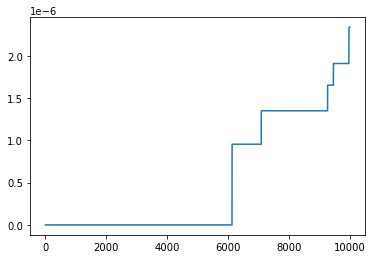

In [155]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
neigh = NearestNeighbors(n_neighbors=20)
nbrs = neigh.fit(features_l)
distances, indices = nbrs.kneighbors(features_l)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

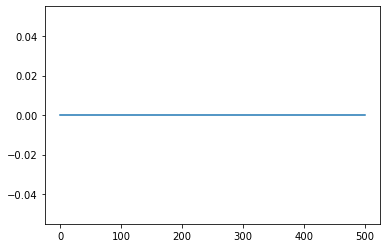

In [156]:
plt.plot(distances[:500])

In [186]:
n = 10
l = 20
indexes = np.sort(np.random.choice(20, size=10))
# np.arange(l)[indexes]
np.array([str(i) for i in range(l)])[indexes]

array(['0', '1', '2', '4', '5', '8', '15', '17', '19', '19'], dtype='<U2')

In [194]:
def pretty_num(n):
    if n < 1e3:
        return str(n)
    if n < 1e6:
        return str(round(n/1e3, 2)) + ' k'
    return str(round(n/1e6, 2)) + ' M'

In [196]:
pretty_num(415637338)

'415.64 M'

## Debug for bimol csearch

In [1]:
from tscode.embedder import Embedder
from tscode.operators import csearch_operator

embedder = Embedder(r'C:\Users\Nik\Desktop\debug\debug.txt')


O***********************************************************O
*  /             ___  __   __   __   __   ___            \  *
* /_____________  |  /__` /  ` /  \ |  \ |__  ____________\ *
*/                |  .__/ \__, \__/ |__/ |___              \*
*                                                           *
*           Transition State Conformational Docker          *
*                       Version 0.1.0                       *
*\                                                         /*
* \    Nicolo' Tampellini - nicolo.tampellini@yale.edu    / *
*  \                                                     /  *
O***********************************************************O



In [2]:
csearch_operator(r'C:\Users\Nik\Desktop\debug\cat_salt.xyz_conf0.xyz', embedder)

--> Performing conformational search on C:\Users\Nik\Desktop\debug\cat_salt.xyz_conf0.xyz


SegmentedGraphError: C:\Users\Nik\Desktop\debug\cat_salt.xyz_conf0.xyz_conf0 has a segmented connectivity graph: double check the input geometry.
if this is supposed to be a complex, TSCoDe was not able to find hydrogen bonds
connecting the molecules, and the algorithm is not designed to reliably perform
conformational searches on loosely bound multimolecular arrangements.

In [1]:
## Clash_thresh sample

In [28]:
from tscode.python_functions import compenetration_check
from tscode.utils import read_xyz
data = read_xyz(r'C:\Users\Nik\Desktop\debug\TSCoDe_embedded_Apr__4_03-29.xyz')
data.atomcoords.shape

(1000, 137, 3)

In [29]:
from tscode.algebra import all_dists
import numpy as np
import matplotlib.pyplot as plt

ids = [102,0]
min_ds = []
for coords in data.atomcoords:

    m1 = coords[0:ids[0]]
    m2 = coords[ids[0]:]
    # fragment identification by length (contiguous)

    d = all_dists(m2,m1)
    m = np.min(d)
    # print(m)
    # print(np.where(d==m))

    min_ds.append(m)

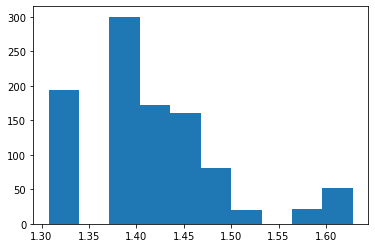

In [30]:

plot = plt.hist(min_ds, bins=10)

In [32]:
from tscode.utils import write_xyz
thr = 1.5
out = []

for c in data.atomcoords:
    m1 = c[0:102]
    m2 = c[102:]

    d = all_dists(m2,m1)
    m = np.min(d)

    if m > thr:
        out.append(c)

out = np.array(out)

with open(r'C:\Users\Nik\Desktop\debug\clean.xyz', 'w') as f:
    for s in out:
        write_xyz(s, data.atomnos, f)

out.shape


(93, 137, 3)

## OB UFF convergence
### Actually kinda bad. 200 is fast and loose, 500 seems to be a good amount

In [8]:
from openbabel import openbabel as ob
import matplotlib.pyplot as plt
import numpy as np
    
def nsteps_plot(filename):

    # Standard openbabel molecule load
    conv = ob.OBConversion()
    conv.SetInAndOutFormats('xyz','xyz')
    mol = ob.OBMol()
    more = conv.ReadFile(mol, filename)
    i = 0

    # Define constraints
    constraints = ob.OBFFConstraints()

    # constraints.AddTorsionConstraint(1, 2, 3, 4, 180.0) # Degrees

    # Setup the force field with the constraints
    forcefield = ob.OBForceField.FindForceField('UFF')
    forcefield.Setup(mol, constraints)
    forcefield.SetConstraints(constraints)

    # Do a nsteps conjugate gradient minimization
    # (or less if converges) and save the coordinates to mol.
    energies = []
    for n in range(1,1001):
        forcefield.ConjugateGradients(1)
        forcefield.GetCoordinates(mol)
        energy = forcefield.Energy() * 0.2390057361376673 # kJ/mol to kcal/mol

        energies.append(energy)

    energies = np.array(energies)
    plt.plot(energies-min(energies))
    plt.show()

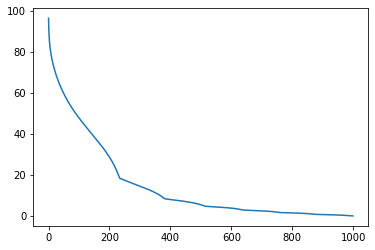

In [9]:
nsteps_plot(r'C:\Users\Nik\Desktop\debug\aug\start.xyz')

In [12]:
def nsteps_plot_sd(filename):

    # Standard openbabel molecule load
    conv = ob.OBConversion()
    conv.SetInAndOutFormats('xyz','xyz')
    mol = ob.OBMol()
    more = conv.ReadFile(mol, filename)
    i = 0

    # Define constraints
    constraints = ob.OBFFConstraints()

    # constraints.AddTorsionConstraint(1, 2, 3, 4, 180.0) # Degrees

    # Setup the force field with the constraints
    forcefield = ob.OBForceField.FindForceField('UFF')
    forcefield.Setup(mol, constraints)
    forcefield.SetConstraints(constraints)

    # Do a nsteps conjugate gradient minimization
    # (or less if converges) and save the coordinates to mol.
    energies = []
    for n in range(1,1001):
        forcefield.SteepestDescent(1)
        forcefield.GetCoordinates(mol)
        energy = forcefield.Energy() * 0.2390057361376673 # kJ/mol to kcal/mol

        energies.append(energy)

    energies = np.array(energies)
    plt.plot(energies-min(energies))
    plt.show()

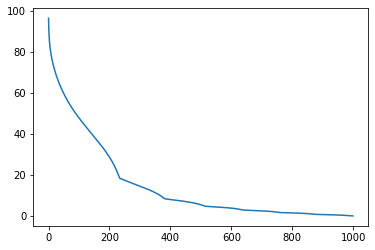

In [13]:
nsteps_plot_sd(r'C:\Users\Nik\Desktop\debug\aug\start.xyz')

## is conf aug giving ok energies?
### Yes, but minor adjustments in the constrained distance can make great energy differences, and we don't want that actually

In [23]:
import numpy as np
from tscode.utils import read_xyz
from tscode.calculators._openbabel import openbabel_opt
m0 = read_xyz(r'C:\Users\Nik\Desktop\debug\aug\best_of_aug_run_0.xyz')
m1 = read_xyz(r'C:\Users\Nik\Desktop\debug\aug\best_of_aug_run_1.xyz')
m2 = read_xyz(r'C:\Users\Nik\Desktop\debug\aug\best_of_aug_run_2.xyz')

In [17]:
_, e0, _ = openbabel_opt(m0.atomcoords[0], m0.atomnos, (), nsteps=0)
_, e1, _ = openbabel_opt(m1.atomcoords[0], m1.atomnos, (), nsteps=0)
_, e2, _ = openbabel_opt(m2.atomcoords[0], m2.atomnos, (), nsteps=0)
print(e0)
print(e1)
print(e2)

642.8060877951402
629.751825420276
623.0391161767941


In [18]:
print(e1-e0)
print(e2-e0)

-13.054262374864265
-19.766971618346133


In [22]:
n = 10000
m0_, e0_, _ = openbabel_opt(m0.atomcoords[0], m0.atomnos, [[39, 136]], nsteps=n)
m1_, e1_, _ = openbabel_opt(m1.atomcoords[0], m1.atomnos, [[39, 136]], nsteps=n)
m2_, e2_, _ = openbabel_opt(m2.atomcoords[0], m2.atomnos, [[39, 136]], nsteps=n)
print(e0_)
print(e1_)
print(e2_)
print(e0_-e0)
print(e1_-e1)
print(e2_-e2)

625.9908623686828
620.0405332127516
619.1433114323739
-16.81522542645746
-9.711292207524366
-3.895804744420161


In [26]:
d0 = np.linalg.norm(m0_[39]-m0_[136])
d1 = np.linalg.norm(m1_[39]-m1_[136])
d2 = np.linalg.norm(m2_[39]-m2_[136])
print(d0)
print(d1)
print(d2)
print(d0-d1)
print(d0-d2)

1.8600563874786162
1.8706799948147197
1.8804921293640129
-0.010623607336103458
-0.020435741885396652


### Let's see if microscopic deviations cause that energy increase with the XTB GFN-FF calculator

In [ ]:
...